# City2TABULA Validation Notebook

This notebook validates the calculations performed by the City2TABULA pipeline by comparing calculated building attributes against source thematic data from CityGML/CityJSON datasets.

## Validation Strategy

1. **Building-Level Attributes**: Height, footprint area, aggregated surface areas
2. **Surface-Level Attributes**: Individual surface area, tilt (roof only), azimuth (roof only)

The validation uses a configuration-driven approach where source property names are mapped to City2TABULA calculated columns via YAML configuration files.

## Stage 0: Load Configuration and Setup Database Connection

Load the validation configuration from YAML file based on the `COUNTRY` environment variable. The configuration contains:
- Dataset information and metadata
- Attribute mappings (source property names → City2TABULA columns)
- Database connection settings (automatically configured)
- Validation tolerances

In [1]:
# Add parent directory to Python path to import validation modules
import sys
import os

# Get the notebook directory
notebook_dir = os.getcwd()
print(f"Notebook directory: {notebook_dir}")

# Add to path (no need to go up if already in validation/)
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# Now import from modules
from modules.config import load_config, print_config_summary
from modules.db import get_db_engine

# Get country from environment variable
country = os.getenv('COUNTRY', 'germany').lower()

# Build path to config file
config_path = os.path.join('configs', f'config_{country}.yaml')

# Load configuration
print(f"\nLoading configuration from: config_{country}.yaml")
config = load_config(config_path)

# Display configuration summary
print_config_summary(config)

# Set up output directory
output_dir = os.path.join('outputs')
os.makedirs(output_dir, exist_ok=True)
print(f"\nOutput directory: {output_dir}")

# Initialize database engine
print("\nInitializing database connection...")
db_engine = get_db_engine(config)
print(f"Connected to database: city2tabula_{country}")

Notebook directory: /home/jayravani/Projects/Work/City2TABULA/github/City2TABULA/validation

Loading configuration from: config_germany.yaml
Loaded configuration for: Germany

CONFIGURATION SUMMARY

 Dataset: LoD2 Dataset of Bavaria
   Country: Germany
   LoD: 2
   Description: Bavarian 3D city models in CityGML format with German property names

 Building Attributes:
   min_height           <- 'value' (m)
   max_height           <- 'value' (m)
   footprint_area       <- 'Flaeche' (m²)

 Surface Attributes:
   ROOF:
   surface_area         <- 'Flaeche' (m²)
   tilt                 <- 'Dachneigung' (degrees)
   azimuth              <- 'Dachorientierung' (degrees)
   WALL:
   surface_area         <- 'Flaeche' (m²)
   FLOOR:
   surface_area         <- 'Flaeche' (m²)

 Validation Tolerances:
   Absolute:
   height               ±0.5
   tilt                 ±2.0
   azimuth              ±5.0
   Percentage:
   footprint_area       ±5.0%
   surface_area         ±5.0%

Output directory: outputs

## Stage 1: Load Data from PostgreSQL Database

Load calculated data from City2TABULA tables and extract attribute mappings from config.

In [2]:
from modules.utils import load_city2tabula_data

# Load calculated data from City2TABULA tables
bf_df, sf_df = load_city2tabula_data(db_engine, config)

print("\nData loading complete.")
display(bf_df.head())
display(sf_df.head())

Loading building features from city2tabula.lod2_building_feature...
Loaded 13395 buildings
Loading surface features from city2tabula.lod2_child_feature_surface...
Loaded 182943 surfaces

Data loading complete.


,id,building_feature_id,tabula_variant_code_id,tabula_variant_code,construction_year,comment,heating_demand,heating_demand_unit,footprint_area,footprint_complexity,...,area_total_roof_unit,area_total_wall,area_total_wall_unit,area_total_floor,area_total_floor_unit,surface_count_floor,surface_count_roof,surface_count_wall,building_centroid_geom,building_footprint_geom
0,f523e768-6e97-40cb-8a0b-4a5431d35e0a,1,158,DE.N.TH.12.Gen.ReEx.001.001,None,None,None,None,57.672950,1,...,sqm,217.986791,sqm,173.018850,sqm,0,3,7,0101000020E86400008AC67C7DCB4A2841E4083DE314A6...,01060000A0E86400000100000001030000800100000007...
1,eaa0b3f0-057b-4e37-8ef1-b2e0fc6435e9,11,40,DE.N.MFH.07.Gen.ReEx.001.001,None,None,None,None,208.862159,1,...,sqm,434.549395,sqm,626.586477,sqm,0,3,7,0101000020E864000079DC2F4384502841234AED20A6A6...,01060000A0E86400000100000001030000800100000007...
2,da7f69bc-7817-4f5b-a502-b2ed37acec0f,12,73,DE.N.SFH.02.Gen.ReEx.001.001,None,None,None,None,88.997573,1,...,sqm,196.144942,sqm,266.992719,sqm,0,2,4,0101000020E86400000DE62423695028419190F787AAA6...,01060000A0E86400000100000001030000800100000005...
3,e221e25f-8c63-4d37-a209-43c6f5aa45ce,27,40,DE.N.MFH.07.Gen.ReEx.001.001,None,None,None,None,153.240391,1,...,sqm,412.240921,sqm,612.961566,sqm,0,4,10,0101000020E8640000CBCD5179774F28413B1044BC2EA6...,01060000A0E86400000100000001030000800100000009...
4,e8febd6d-7ee4-4999-9efd-03b5b40fa1ce,38,22,DE.N.MFH.01.Gen.ReEx.001.001,None,None,None,None,284.096555,1,...,sqm,767.681928,sqm,1420.482773,sqm,0,5,10,0101000020E8640000C1522E824F4F2841621976B337A6...,01060000A0E86400000100000001030000800100000008...


,surface_feature_id,building_feature_id,objectclass_id,classname,surface_area,tilt,azimuth,is_valid,is_planar,geom
0,142321,142316,712,RoofSurface,22.985281,62.987327,329.496795,True,True,"POLYGON Z ((791147.375 5421027.102 422.194,791..."
1,142118,142127,709,WallSurface,12.192849,0.000000,-1.000000,False,True,"POLYGON Z ((791148.133 5420870.024 414.94,7911..."
2,145420,145418,709,WallSurface,13.164673,0.000000,-1.000000,False,True,"POLYGON Z ((791149.17 5420799.51 410.64,791149..."
3,143241,143234,709,WallSurface,13.723538,0.000000,-1.000000,False,True,"POLYGON Z ((791125.18 5421989.09 428.26,791125..."
4,144522,144517,710,GroundSurface,29.584600,90.000000,90.000000,True,True,"POLYGON Z ((790438.6 5421677.37 327.012,790435..."


## Stage 2: Validate Surface Attributes

Validate calculated surface attributes (area, tilt, azimuth) against source thematic data.

In [3]:
from modules.utils import load_thematic_building_data, load_thematic_surface_data
from modules.validators import validate_building_attributes, validate_surface_attributes, get_validation_summary
from modules.config import get_building_attribute_mapping, get_surface_attribute_mapping
import pandas as pd

# =============================================================================
# BUILDING-LEVEL VALIDATION
# =============================================================================
print("="*80)
print("BUILDING-LEVEL ATTRIBUTE VALIDATION")
print("="*80)

# Get building attribute mapping
building_attr_map = get_building_attribute_mapping(config)
print(f"\nValidating {len(building_attr_map)} building attributes:")
for attr, label in building_attr_map.items():
    print(f"  • {attr}: '{label}'")

# Get building IDs
building_ids = bf_df['building_feature_id'].tolist()
print(f"\nBuildings to validate: {len(building_ids)}")

# Load thematic data from CityDB
building_thematic_df = load_thematic_building_data(
    engine=db_engine,
    config=config,
    building_feature_ids=building_ids,
    attribute_mapping=building_attr_map
)

# Validate building attributes
building_validation_df = validate_building_attributes(
    building_calc_df=bf_df,
    building_thematic_df=building_thematic_df,
    attribute_mapping=building_attr_map
)

# Display summary
if not building_validation_df.empty:
    building_summary = get_validation_summary(building_validation_df)
    print("\n" + "="*80)
    print("BUILDING VALIDATION SUMMARY")
    print("="*80)
    display(building_summary)
else:
    print("No building validation results")

# =============================================================================
# SURFACE-LEVEL VALIDATION (ROOFS)
# =============================================================================
print("\n" + "="*80)
print("ROOF SURFACE ATTRIBUTE VALIDATION")
print("="*80)

# Get roof attribute mapping
roof_attr_map = get_surface_attribute_mapping(config, 'roof')
print(f"\nValidating {len(roof_attr_map)} roof attributes:")
for attr, label in roof_attr_map.items():
    print(f"  • {attr}: '{label}'")

# Filter for roof surfaces
roof_surfaces_df = sf_df[sf_df['classname'] == 'RoofSurface'].copy()
roof_ids = roof_surfaces_df['surface_feature_id'].tolist()
print(f"\nRoof surfaces to validate: {len(roof_ids)}")

if roof_ids:
    # Load thematic data from CityDB
    roof_thematic_df = load_thematic_surface_data(
        engine=db_engine,
        config=config,
        surface_feature_ids=roof_ids,
        attribute_mapping=roof_attr_map,
        surface_type='RoofSurface'
    )

    # Validate roof attributes
    roof_validation_df = validate_surface_attributes(
        surface_calc_df=sf_df,
        surface_thematic_df=roof_thematic_df,
        attribute_mapping=roof_attr_map,
        surface_type='RoofSurface'
    )

    # Display summary
    if not roof_validation_df.empty:
        roof_summary = get_validation_summary(roof_validation_df)
        print("\n" + "="*80)
        print("ROOF VALIDATION SUMMARY")
        print("="*80)
        display(roof_summary)
    else:
        print("No roof validation results")
else:
    print("No roof surfaces found")
    roof_validation_df = pd.DataFrame()

# =============================================================================
# SURFACE-LEVEL VALIDATION (WALLS)
# =============================================================================
print("\n" + "="*80)
print("WALL SURFACE ATTRIBUTE VALIDATION")
print("="*80)

# Get wall attribute mapping
wall_attr_map = get_surface_attribute_mapping(config, 'wall')
print(f"\nValidating {len(wall_attr_map)} wall attributes:")
for attr, label in wall_attr_map.items():
    print(f"  • {attr}: '{label}'")

# Filter for wall surfaces
wall_surfaces_df = sf_df[sf_df['classname'] == 'WallSurface'].copy()
wall_ids = wall_surfaces_df['surface_feature_id'].tolist()
print(f"\nWall surfaces to validate: {len(wall_ids)}")

if wall_ids and wall_attr_map:
    # Load thematic data from CityDB
    wall_thematic_df = load_thematic_surface_data(
        engine=db_engine,
        config=config,
        surface_feature_ids=wall_ids,
        attribute_mapping=wall_attr_map,
        surface_type='WallSurface'
    )

    # Validate wall attributes
    wall_validation_df = validate_surface_attributes(
        surface_calc_df=sf_df,
        surface_thematic_df=wall_thematic_df,
        attribute_mapping=wall_attr_map,
        surface_type='WallSurface'
    )

    # Display summary
    if not wall_validation_df.empty:
        wall_summary = get_validation_summary(wall_validation_df)
        print("\n" + "="*80)
        print("WALL VALIDATION SUMMARY")
        print("="*80)
        display(wall_summary)
    else:
        print("No wall validation results")
else:
    print("No wall surfaces or attributes to validate")
    wall_validation_df = pd.DataFrame()

# =============================================================================
# SURFACE-LEVEL VALIDATION (FLOORS/GROUND)
# =============================================================================
print("\n" + "="*80)
print("FLOOR/GROUND SURFACE ATTRIBUTE VALIDATION")
print("="*80)

# Get floor attribute mapping
floor_attr_map = get_surface_attribute_mapping(config, 'floor')
print(f"\nValidating {len(floor_attr_map)} floor attributes:")
for attr, label in floor_attr_map.items():
    print(f"  • {attr}: '{label}'")

# Filter for ground surfaces
floor_surfaces_df = sf_df[sf_df['classname'] == 'GroundSurface'].copy()
floor_ids = floor_surfaces_df['surface_feature_id'].tolist()
print(f"\nFloor/Ground surfaces to validate: {len(floor_ids)}")

if floor_ids and floor_attr_map:
    # Load thematic data from CityDB
    floor_thematic_df = load_thematic_surface_data(
        engine=db_engine,
        config=config,
        surface_feature_ids=floor_ids,
        attribute_mapping=floor_attr_map,
        surface_type='GroundSurface'
    )

    # Validate floor attributes
    floor_validation_df = validate_surface_attributes(
        surface_calc_df=sf_df,
        surface_thematic_df=floor_thematic_df,
        attribute_mapping=floor_attr_map,
        surface_type='GroundSurface'
    )

    # Display summary
    if not floor_validation_df.empty:
        floor_summary = get_validation_summary(floor_validation_df)
        print("\n" + "="*80)
        print("FLOOR/GROUND VALIDATION SUMMARY")
        print("="*80)
        display(floor_summary)
    else:
        print("No floor validation results")
else:
    print("No floor/ground surfaces or attributes to validate")
    floor_validation_df = pd.DataFrame()

BUILDING-LEVEL ATTRIBUTE VALIDATION

Validating 3 building attributes:
  • min_height: 'value'
  • max_height: 'value'
  • footprint_area: 'Flaeche'

Buildings to validate: 13395
Loaded thematic data for 26790 building attribute values
Validated 26790 building attribute values across 13395 buildings

BUILDING VALIDATION SUMMARY


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,max_height,13395,2.7349,2.1366,3.4705,51.9351,33.0475,70.2558
1,min_height,13395,0.8831,2.0799,2.2595,26.1437,0.0000,72.5058



ROOF SURFACE ATTRIBUTE VALIDATION

Validating 3 roof attributes:
  • surface_area: 'Flaeche'
  • tilt: 'Dachneigung'
  • azimuth: 'Dachorientierung'

Roof surfaces to validate: 37897
Loaded thematic data for 86541 RoofSurface attribute values
Validated 113691 RoofSurface attribute values across 28847 surfaces

ROOF VALIDATION SUMMARY


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,azimuth,37897,14.0122,49.5566,51.4988,-1075.9045,-0.0012,13169.5064
1,surface_area,37897,-1.0015,18.4952,18.5220,-1.4005,-0.0000,8.4667
2,tilt,37897,-0.4559,7.0168,7.0315,-0.2696,0.0000,73.0033



WALL SURFACE ATTRIBUTE VALIDATION

Validating 1 wall attributes:
  • surface_area: 'Flaeche'

Wall surfaces to validate: 125863
Loaded thematic data for 90376 WallSurface attribute values
Validated 125863 WallSurface attribute values across 90376 surfaces

WALL VALIDATION SUMMARY


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,surface_area,125863,-1.8679,29.2062,29.2657,-2.4611,0.0001,16.3396



FLOOR/GROUND SURFACE ATTRIBUTE VALIDATION

Validating 1 floor attributes:
  • surface_area: 'Flaeche'

Floor/Ground surfaces to validate: 19183
Loaded thematic data for 13395 GroundSurface attribute values
Validated 19183 GroundSurface attribute values across 13395 surfaces

FLOOR/GROUND VALIDATION SUMMARY


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,surface_area,19183,0.0104,0.1947,0.1949,0.0088,0.0,0.0325


In [4]:
# =============================================================================
# SAVE VALIDATION RESULTS
# =============================================================================
import os
from datetime import datetime

# Create timestamped output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join(output_dir, config.get('dataset', {}).get('country', 'unknown'), f"validation_{timestamp}")
os.makedirs(results_dir, exist_ok=True)

print(f"\nSaving validation results to: {results_dir}")

# Save building validation results
if not building_validation_df.empty:
    building_output = os.path.join(results_dir, "building_validation.csv")
    building_validation_df.to_csv(building_output, index=False)
    print(f"Saved building validation: {building_output}")
    
    building_summary_output = os.path.join(results_dir, "building_summary.csv")
    building_summary.to_csv(building_summary_output, index=False)
    print(f"Saved building summary: {building_summary_output}")

# Save roof validation results
if not roof_validation_df.empty:
    roof_output = os.path.join(results_dir, "roof_validation.csv")
    roof_validation_df.to_csv(roof_output, index=False)
    print(f"Saved roof validation: {roof_output}")
    
    roof_summary_output = os.path.join(results_dir, "roof_summary.csv")
    roof_summary.to_csv(roof_summary_output, index=False)
    print(f"Saved roof summary: {roof_summary_output}")

# Save wall validation results
if not wall_validation_df.empty:
    wall_output = os.path.join(results_dir, "wall_validation.csv")
    wall_validation_df.to_csv(wall_output, index=False)
    print(f"Saved wall validation: {wall_output}")
    
    wall_summary_output = os.path.join(results_dir, "wall_summary.csv")
    wall_summary.to_csv(wall_summary_output, index=False)
    print(f"Saved wall summary: {wall_summary_output}")

# Save floor validation results
if not floor_validation_df.empty:
    floor_output = os.path.join(results_dir, "floor_validation.csv")
    floor_validation_df.to_csv(floor_output, index=False)
    
    floor_summary_output = os.path.join(results_dir, "floor_summary.csv")
    floor_summary.to_csv(floor_summary_output, index=False)
    print(f"Saved floor summary: {floor_summary_output}")

print(f"\n{'='*80}")
print("RESULTS SAVED")
print(f"{'='*80}")


Saving validation results to: outputs/Germany/validation_20251202_145359
Saved building validation: outputs/Germany/validation_20251202_145359/building_validation.csv
Saved building summary: outputs/Germany/validation_20251202_145359/building_summary.csv
Saved roof validation: outputs/Germany/validation_20251202_145359/roof_validation.csv
Saved roof summary: outputs/Germany/validation_20251202_145359/roof_summary.csv
Saved wall validation: outputs/Germany/validation_20251202_145359/wall_validation.csv
Saved wall summary: outputs/Germany/validation_20251202_145359/wall_summary.csv
Saved floor summary: outputs/Germany/validation_20251202_145359/floor_summary.csv

RESULTS SAVED


## Stage 2.5: Export Problematic Buildings

Identify buildings with surfaces that have high validation errors and export them with geometries for inspection in QGIS.

In [5]:
from modules.validators import export_problematic_surfaces

# =============================================================================
# EXPORT PROBLEMATIC SURFACES WITH GEOMETRIES
# =============================================================================

# Define error threshold (percentage error to flag as problematic)
error_threshold = 10.0

print("="*80)
print("EXPORTING PROBLEMATIC SURFACES")
print(f"Error threshold: {error_threshold}%")
print("="*80)

# Export problematic roofs
if not roof_validation_df.empty:
    print("\n--- Roof Surfaces ---")
    roof_prob_file = os.path.join(results_dir, 'problematic_roofs.csv')
    roof_prob = export_problematic_surfaces(roof_validation_df, roof_prob_file, error_threshold)

# Export problematic walls
if not wall_validation_df.empty:
    print("\n--- Wall Surfaces ---")
    wall_prob_file = os.path.join(results_dir, 'problematic_walls.csv')
    wall_prob = export_problematic_surfaces(wall_validation_df, wall_prob_file, error_threshold)

# Export problematic floors
if not floor_validation_df.empty:
    print("\n--- Floor Surfaces ---")
    floor_prob_file = os.path.join(results_dir, 'problematic_floors.csv')
    floor_prob = export_problematic_surfaces(floor_validation_df, floor_prob_file, error_threshold)

print("\n" + "="*80)
print("PROBLEMATIC SURFACES EXPORT COMPLETE")
print("="*80)
print("\nFiles contain: building_feature_id, surface_feature_id, geometry (WKT),")
print("              calculated_value, thematic_value, difference, percent_error")
print("\nTo visualize in QGIS:")
print("1. Layer → Add Layer → Add Delimited Text Layer")
print("2. Select the problematic_*.csv file")
print("3. Geometry definition → Well-Known Text (WKT)")
print("4. Geometry field: geom")
print("="*80)

EXPORTING PROBLEMATIC SURFACES
Error threshold: 10.0%

--- Roof Surfaces ---

Exported 11291 problematic validations
  - 5975 unique surfaces
  - 6014 unique buildings
  - Saved to: outputs/Germany/validation_20251202_145359/problematic_roofs.csv


--- Wall Surfaces ---

Exported 5233 problematic validations
  - 3954 unique surfaces
  - 3285 unique buildings
  - Saved to: outputs/Germany/validation_20251202_145359/problematic_walls.csv


--- Floor Surfaces ---
No surfaces found with errors above 10.0% threshold

PROBLEMATIC SURFACES EXPORT COMPLETE

Files contain: building_feature_id, surface_feature_id, geometry (WKT),
              calculated_value, thematic_value, difference, percent_error

To visualize in QGIS:
1. Layer → Add Layer → Add Delimited Text Layer
2. Select the problematic_*.csv file
3. Geometry definition → Well-Known Text (WKT)
4. Geometry field: geom


## Stage 3: Generate Validation Plots

Create scatter plots and error distribution visualizations for validated attributes.

GENERATING VALIDATION PLOTS

Generating building attribute plots...
   building_feature_id attribute_name  calculated_value  thematic_value  \
0                    1     min_height             6.546           6.494   
1                   11     min_height             8.607           8.607   
2                   12     min_height             7.110           7.110   
3                   27     min_height             9.990           9.990   
4                   38     min_height            11.980          11.530   

     difference  percent_error  
0  5.200000e-02   8.007391e-01  
1 -2.842171e-14  -3.302162e-13  
2  1.332268e-14   1.873794e-13  
3 -4.796163e-14  -4.800964e-13  
4  4.500000e-01   3.902862e+00  

Generating roof surface attribute plots...
No valid percentage errors for attribute 'tilt'
No valid percentage errors for attribute 'azimuth'

Generating wall surface attribute plots...

Generating floor surface attribute plots...

All plots saved to: outputs/Germany/validation_202

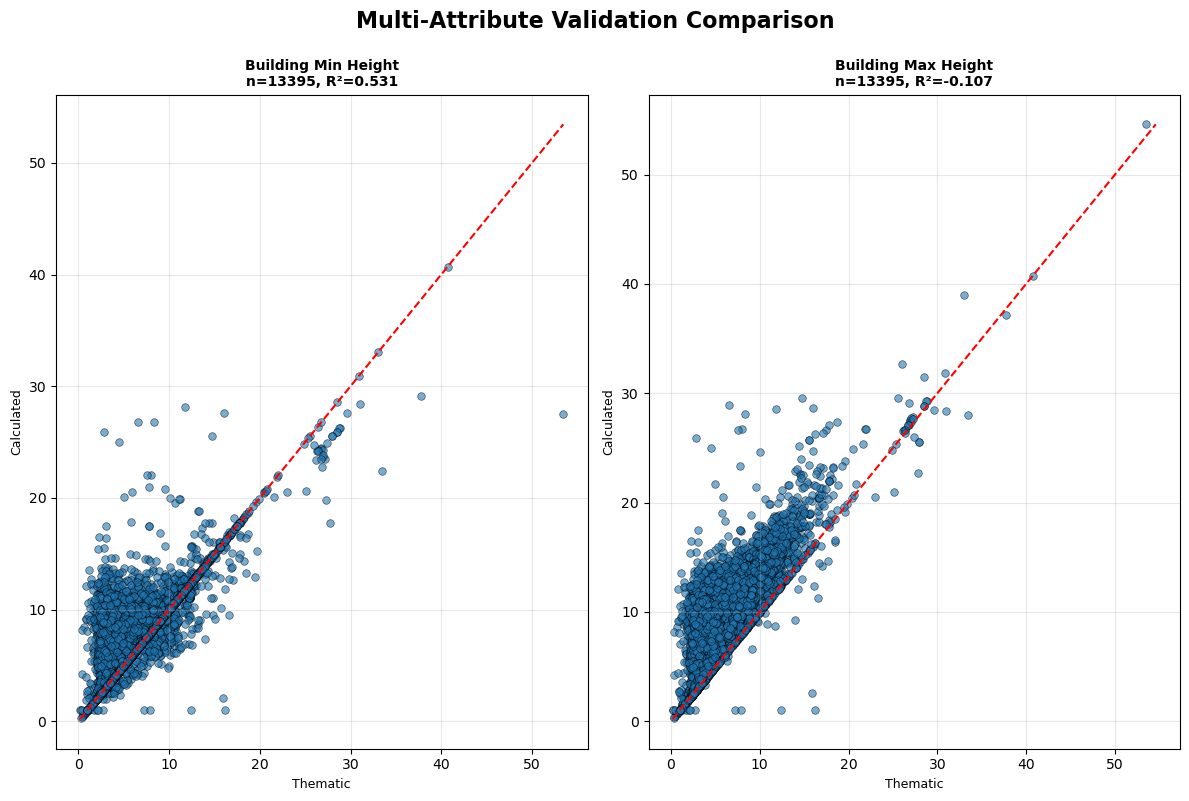

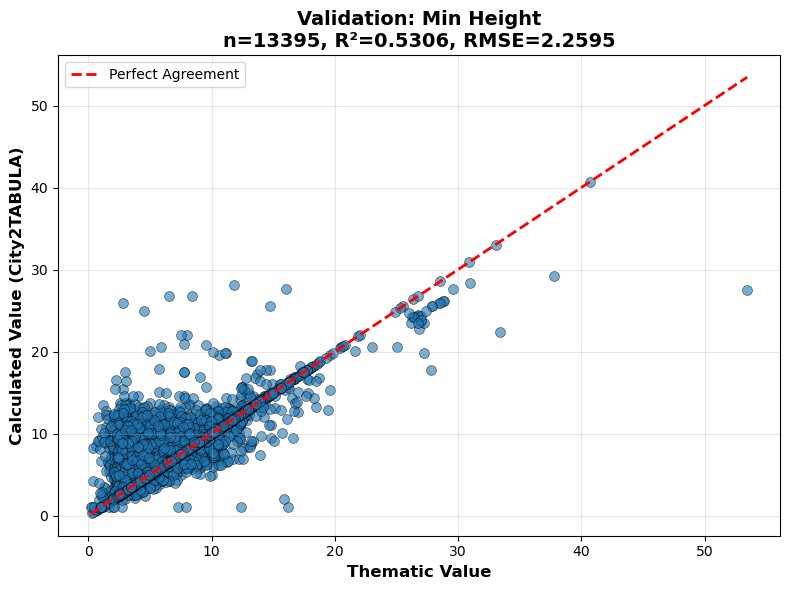

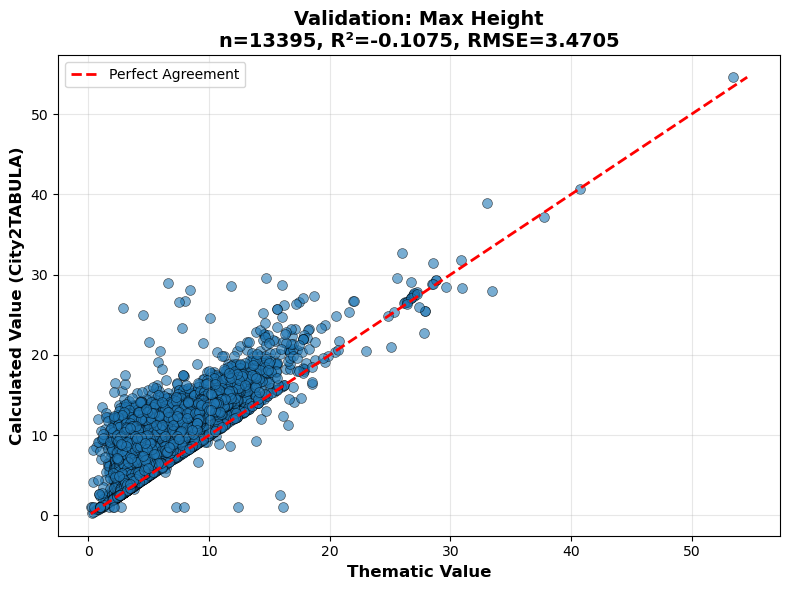

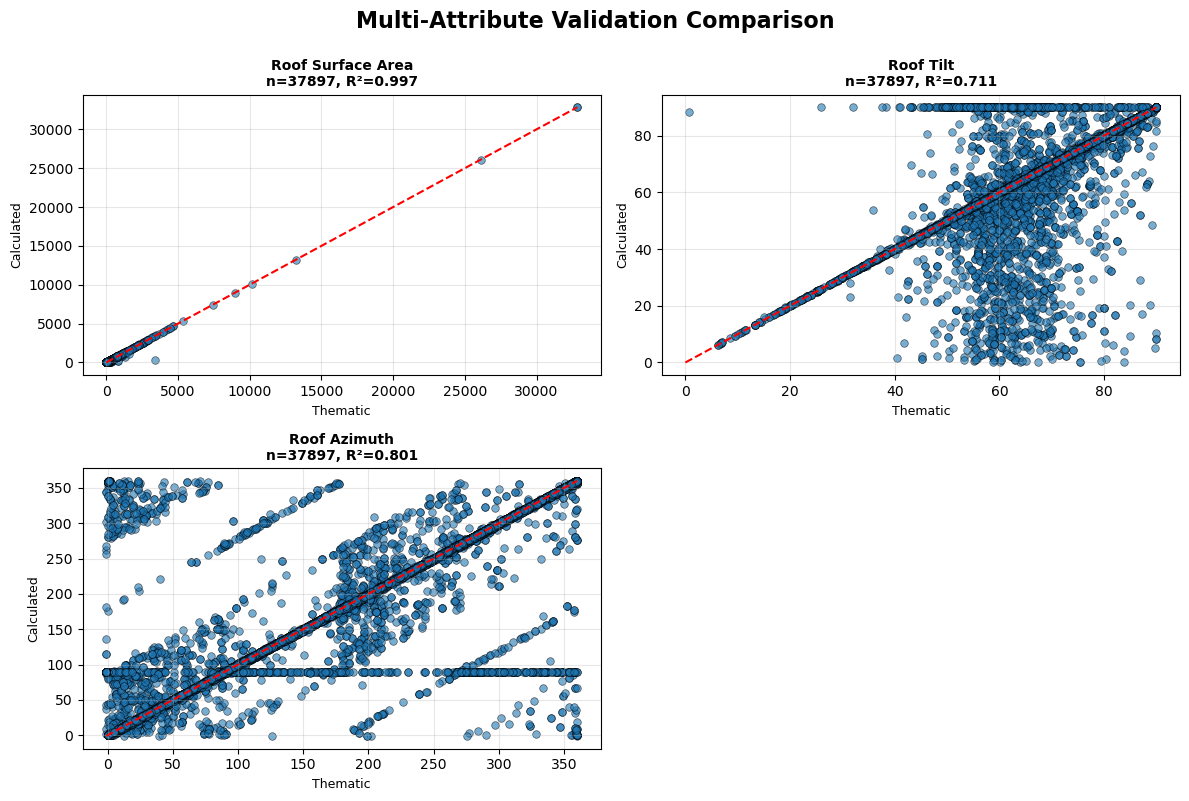

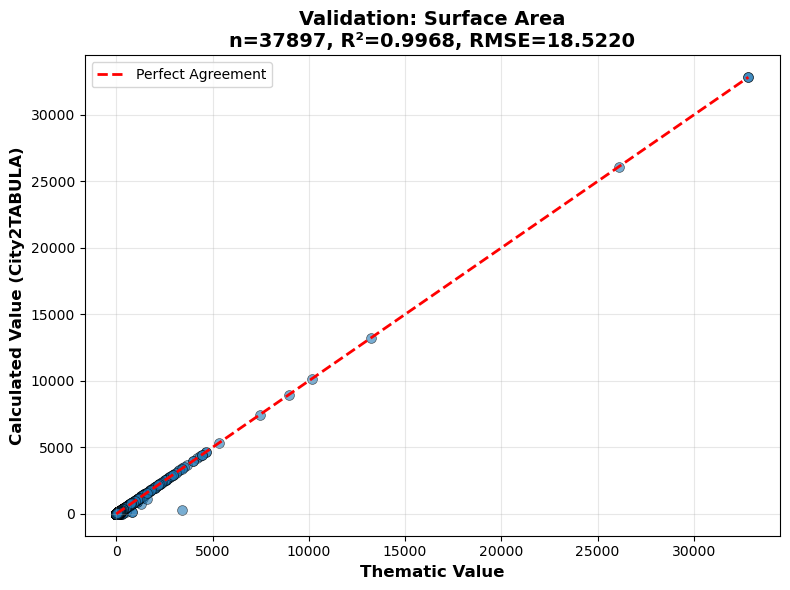

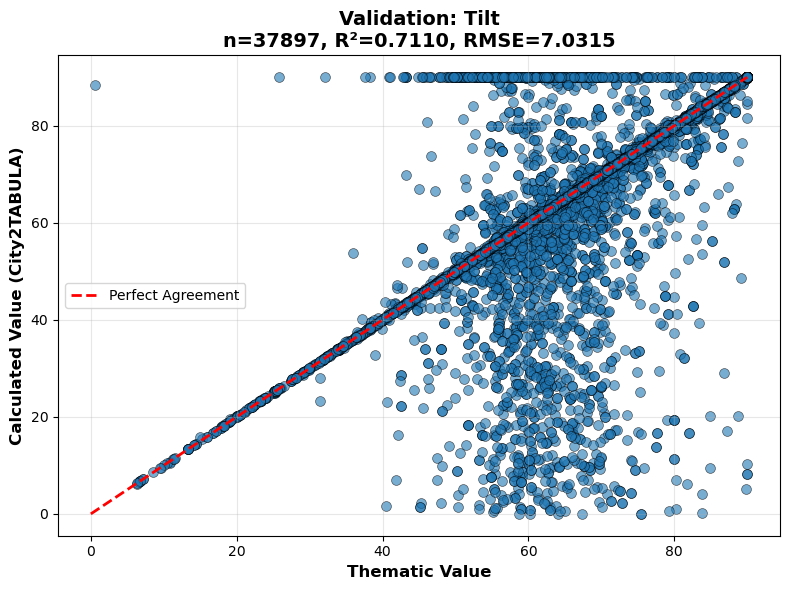

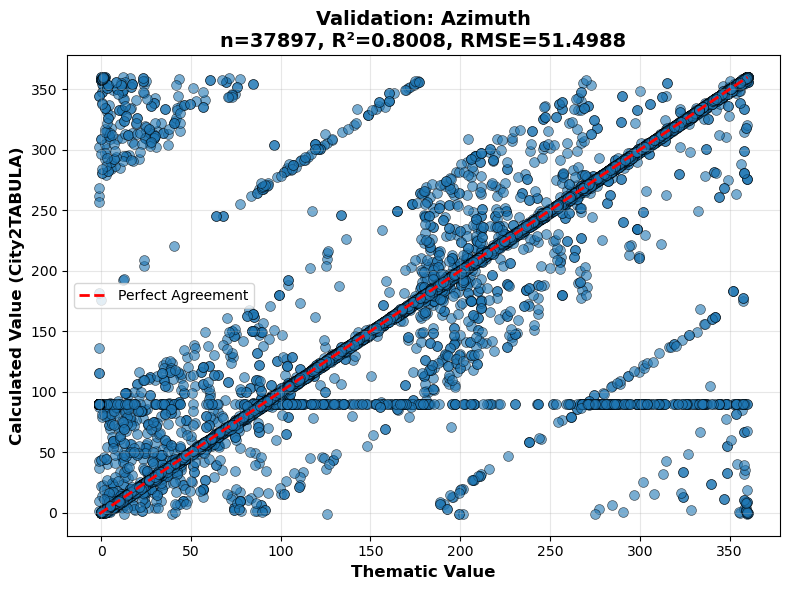

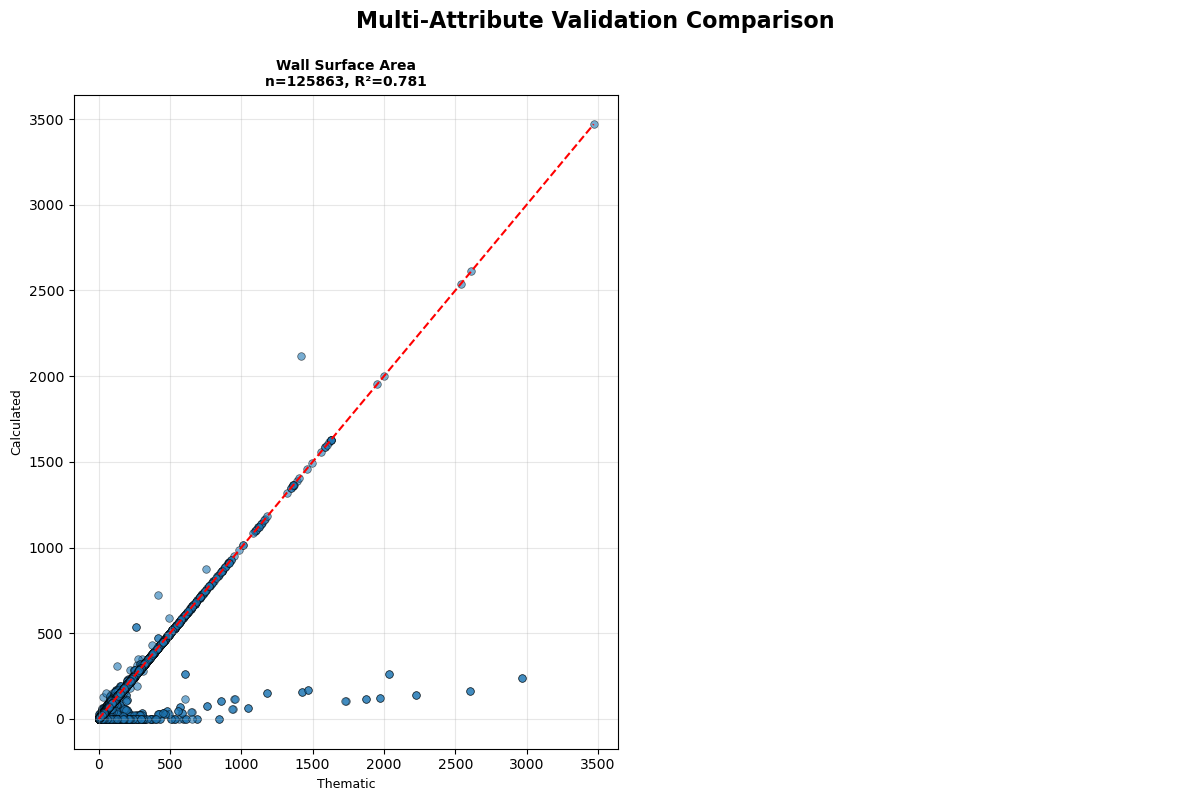

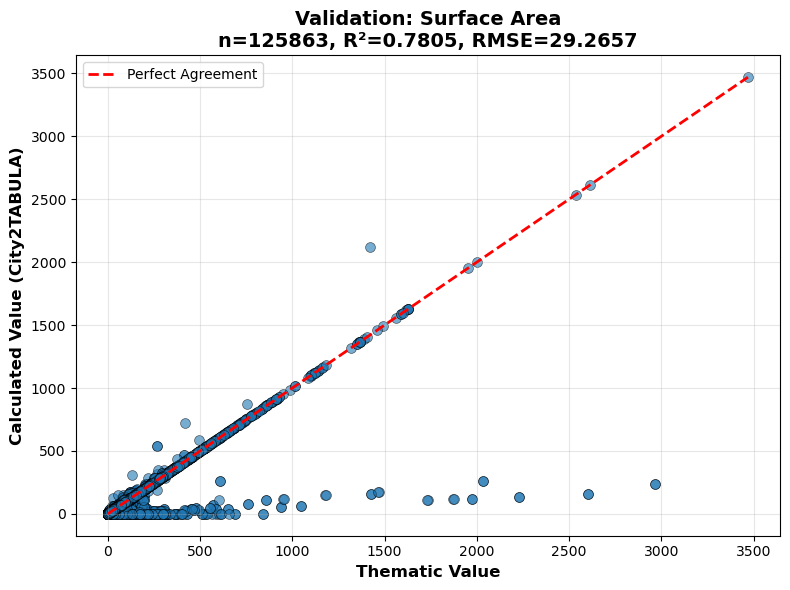

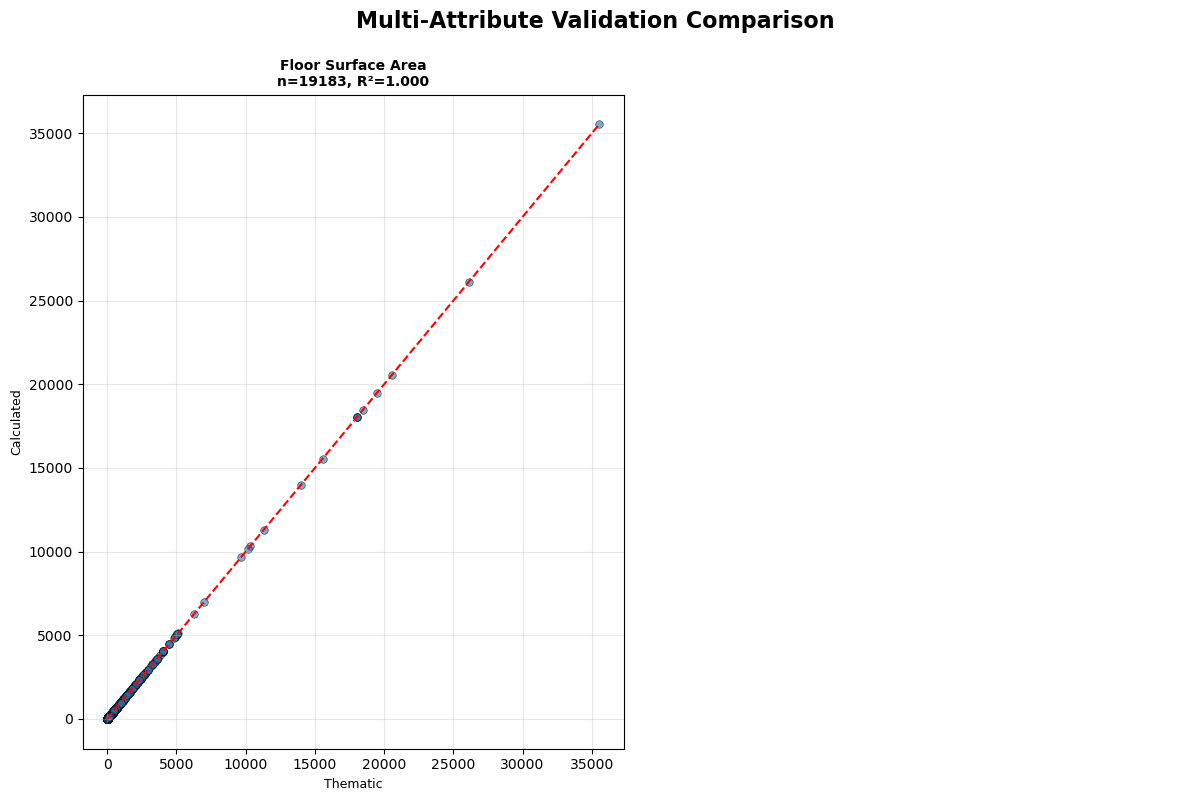

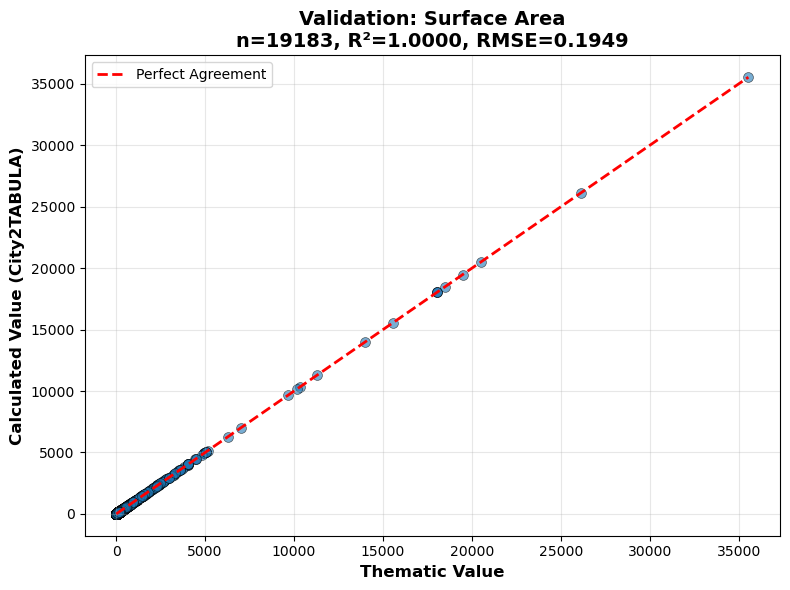

In [6]:
from modules.plots import (plot_comparison_scatter, plot_error_distribution, 
                            plot_percent_error_distribution, plot_multi_attribute_comparison)
import matplotlib.pyplot as plt

# Create plots subdirectory
plots_dir = os.path.join(results_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

print("="*80)
print("GENERATING VALIDATION PLOTS")
print("="*80)

# =============================================================================
# BUILDING ATTRIBUTE PLOTS
# =============================================================================
if not building_validation_df.empty:
    print("\nGenerating building attribute plots...")
    print(building_validation_df.head())
    # Multi-attribute comparison
    plot_multi_attribute_comparison(
        building_validation_df,
        save_path=os.path.join(plots_dir, "building_multi_comparison.png"),
        title_prefix="Building"
    )
    
    # Individual attribute plots
    for attr in building_validation_df['attribute_name'].unique():        
        plot_comparison_scatter(
            building_validation_df, attr,
            save_path=os.path.join(plots_dir, f"building_{attr}_scatter.png")
        )
        
        plot_error_distribution(
            building_validation_df, attr,
            save_path=os.path.join(plots_dir, f"building_{attr}_error_dist.png")
        )
        
        plot_percent_error_distribution(
            building_validation_df, attr,
            save_path=os.path.join(plots_dir, f"building_{attr}_percent_error.png")
        )

# =============================================================================
# ROOF SURFACE ATTRIBUTE PLOTS
# =============================================================================
if not roof_validation_df.empty:
    print("\nGenerating roof surface attribute plots...")
    
    plot_multi_attribute_comparison(
        roof_validation_df,
        save_path=os.path.join(plots_dir, "roof_multi_comparison.png"),
        title_prefix="Roof"
    )
    
    for attr in roof_validation_df['attribute_name'].unique():
        
        plot_comparison_scatter(
            roof_validation_df, attr,
            save_path=os.path.join(plots_dir, f"roof_{attr}_scatter.png")
        )
        
        plot_error_distribution(
            roof_validation_df, attr,
            save_path=os.path.join(plots_dir, f"roof_{attr}_error_dist.png")
        )
        
        plot_percent_error_distribution(
            roof_validation_df, attr,
            save_path=os.path.join(plots_dir, f"roof_{attr}_percent_error.png")
        )

# =============================================================================
# WALL SURFACE ATTRIBUTE PLOTS
# =============================================================================
if not wall_validation_df.empty:
    print("\nGenerating wall surface attribute plots...")
    
    plot_multi_attribute_comparison(
        wall_validation_df,
        save_path=os.path.join(plots_dir, "wall_multi_comparison.png"),
        title_prefix="Wall"
    )
    
    for attr in wall_validation_df['attribute_name'].unique():

        plot_comparison_scatter(
            wall_validation_df, attr,
            save_path=os.path.join(plots_dir, f"wall_{attr}_scatter.png")
        )
        
        plot_error_distribution(
            wall_validation_df, attr,
            save_path=os.path.join(plots_dir, f"wall_{attr}_error_dist.png")
        )
        
        plot_percent_error_distribution(
            wall_validation_df, attr,
            save_path=os.path.join(plots_dir, f"wall_{attr}_percent_error.png")
        )

# =============================================================================
# FLOOR SURFACE ATTRIBUTE PLOTS
# =============================================================================
if not floor_validation_df.empty:
    print("\nGenerating floor surface attribute plots...")
    
    plot_multi_attribute_comparison(
        floor_validation_df,
        save_path=os.path.join(plots_dir, "floor_multi_comparison.png"),
        title_prefix="Floor"
    )
    
    for attr in floor_validation_df['attribute_name'].unique():
        
        plot_comparison_scatter(
            floor_validation_df, attr,
            save_path=os.path.join(plots_dir, f"floor_{attr}_scatter.png")
        )
        
        plot_error_distribution(
            floor_validation_df, attr,
            save_path=os.path.join(plots_dir, f"floor_{attr}_error_dist.png")
        )
        
        plot_percent_error_distribution(
            floor_validation_df, attr,
            save_path=os.path.join(plots_dir, f"floor_{attr}_percent_error.png")
        )

print(f"\nAll plots saved to: {plots_dir}")

## Stage 4: Interpretation & Summary

Review the validation results and summary statistics.

In [7]:
print("="*80)
print("VALIDATION SUMMARY REPORT")
print("="*80)

# =============================================================================
# BUILDING VALIDATION SUMMARY
# =============================================================================
if not building_validation_df.empty:
    print("\n" + "="*80)
    print("BUILDING ATTRIBUTE VALIDATION")
    print("="*80)
    print(f"\nTotal buildings validated: {building_validation_df['building_feature_id'].nunique()}")
    print(f"Total comparisons: {len(building_validation_df)}")
    print("\nValidation Statistics:")
    display(building_summary)
else:
    print("\nNo building validation data available")

# =============================================================================
# ROOF SURFACE VALIDATION SUMMARY
# =============================================================================
if not roof_validation_df.empty:
    print("\n" + "="*80)
    print("ROOF SURFACE ATTRIBUTE VALIDATION")
    print("="*80)
    print(f"\nTotal roof surfaces validated: {roof_validation_df['surface_feature_id'].nunique()}")
    print(f"Total comparisons: {len(roof_validation_df)}")
    print("\nValidation Statistics:")
    display(roof_summary)
else:
    print("\nNo roof surface validation data available")

# =============================================================================
# WALL SURFACE VALIDATION SUMMARY
# =============================================================================
if not wall_validation_df.empty:
    print("\n" + "="*80)
    print("WALL SURFACE ATTRIBUTE VALIDATION")
    print("="*80)
    print(f"\nTotal wall surfaces validated: {wall_validation_df['surface_feature_id'].nunique()}")
    print(f"Total comparisons: {len(wall_validation_df)}")
    print("\nValidation Statistics:")
    display(wall_summary)
else:
    print("\nNo wall surface validation data available")

# =============================================================================
# FLOOR SURFACE VALIDATION SUMMARY
# =============================================================================
if not floor_validation_df.empty:
    print("\n" + "="*80)
    print("FLOOR SURFACE ATTRIBUTE VALIDATION")
    print("="*80)
    print(f"\nTotal floor surfaces validated: {floor_validation_df['surface_feature_id'].nunique()}")
    print(f"Total comparisons: {len(floor_validation_df)}")
    print("\nValidation Statistics:")
    display(floor_summary)
else:
    print("\nNo floor surface validation data available")

# =============================================================================
# OVERALL SUMMARY
# =============================================================================
print("\n" + "="*80)
print("OVERALL VALIDATION SUMMARY")
print("="*80)

total_validations = 0
if not building_validation_df.empty:
    total_validations += len(building_validation_df)
if not roof_validation_df.empty:
    total_validations += len(roof_validation_df)
if not wall_validation_df.empty:
    total_validations += len(wall_validation_df)
if not floor_validation_df.empty:
    total_validations += len(floor_validation_df)

print(f"\nTotal validation comparisons: {total_validations}")
print(f"Results directory: {results_dir}")
print("\n" + "="*80)

VALIDATION SUMMARY REPORT

BUILDING ATTRIBUTE VALIDATION

Total buildings validated: 13395
Total comparisons: 26790

Validation Statistics:


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,max_height,13395,2.7349,2.1366,3.4705,51.9351,33.0475,70.2558
1,min_height,13395,0.8831,2.0799,2.2595,26.1437,0.0000,72.5058



ROOF SURFACE ATTRIBUTE VALIDATION

Total roof surfaces validated: 28847
Total comparisons: 113691

Validation Statistics:


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,azimuth,37897,14.0122,49.5566,51.4988,-1075.9045,-0.0012,13169.5064
1,surface_area,37897,-1.0015,18.4952,18.5220,-1.4005,-0.0000,8.4667
2,tilt,37897,-0.4559,7.0168,7.0315,-0.2696,0.0000,73.0033



WALL SURFACE ATTRIBUTE VALIDATION

Total wall surfaces validated: 90376
Total comparisons: 125863

Validation Statistics:


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,surface_area,125863,-1.8679,29.2062,29.2657,-2.4611,0.0001,16.3396



FLOOR SURFACE ATTRIBUTE VALIDATION

Total floor surfaces validated: 13395
Total comparisons: 19183

Validation Statistics:


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,surface_area,19183,0.0104,0.1947,0.1949,0.0088,0.0,0.0325



OVERALL VALIDATION SUMMARY

Total validation comparisons: 285527
Results directory: outputs/Germany/validation_20251202_145359



## Stage 5: Export Notebook as HTML & PDF

Export this notebook with all outputs to HTML and PDF formats for documentation.

In [ ]:
import subprocess

print("="*80)
print("EXPORTING NOTEBOOK")
print("="*80)

# Get the notebook filename
notebook_path = "validation.ipynb"
notebook_name = os.path.splitext(os.path.basename(notebook_path))[0]

# Export paths
html_output = os.path.join(results_dir, f"{notebook_name}_report.html")
pdf_output = os.path.join(results_dir, f"{notebook_name}_report.pdf")

try: 
    # Export to HTML
    try:
        result = subprocess.run(
            ["jupyter", "nbconvert", "--to", "html", notebook_path, "--output", html_output],
            capture_output=True,
            text=True,
            check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"HTML export failed: {e.stderr}")
    except FileNotFoundError:
        print("jupyter nbconvert not found. Install with: pip install nbconvert")

    # Export to PDF (requires nbconvert and additional dependencies)
    try:
        # Check if wkhtmltopdf or similar is available
        result = subprocess.run(
            ["jupyter", "nbconvert", "--to", "pdf", notebook_path, "--output", pdf_output],
            capture_output=True,
            text=True,
            check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"PDF export failed: {e.stderr}")
        print("   PDF export requires additional dependencies:")
        print("   • Install pandoc: conda install pandoc")
        print("   • Install LaTeX: conda install -c conda-forge texlive-core")
        print("   Alternative: Use HTML export and print to PDF from browser")
    except FileNotFoundError:
        print("jupyter nbconvert not found. Install with: pip install nbconvert")

    print("="*80)
    print("NOTEBOOK EXPORTED SUCCESSFULLY AS PDF & HTML DOCUMENT!")
    print("="*80)

except:
    print("="*80)
    print("NOTEBOOK EXPORTED FAILED!")
    print("="*80)

EXPORTING NOTEBOOK
NOTEBOOK EXPORTED SUCCESSFULLY AS PDF & HTML DOCUMENT!
